# Draw arrowed attention line between patches

In [1]:
from dataService import DataService, draw_arrow_on_image, highlight_patches, rootDir, read_image_from_dataurl64, convert_np_image_to_dataurl64, append_cls, highlight_a_patch, overlay_image_with_attention, complement, hilo
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy

E:\attention-viz\web\


In [2]:
dataService = DataService()

------inited------
bert MatrixData Done! Time elapsed: 0.8664510250091553 seconds
bert AttentionData Done! Time elapsed: 0.462479829788208 seconds
bert AggAttnData Done! Time elapsed: 0.15166306495666504 seconds
bert TokenData Done! Time elapsed: 0.03100728988647461 seconds
gpt MatrixData Done! Time elapsed: 0.8330364227294922 seconds
gpt AttentionData Done! Time elapsed: 0.4230537414550781 seconds
gpt AggAttnData Done! Time elapsed: 0.26108551025390625 seconds
gpt TokenData Done! Time elapsed: 0.030008792877197266 seconds
vit_32 MatrixData Done! Time elapsed: 1.6804187297821045 seconds
vit_32 AttentionData Done! Time elapsed: 4.719078779220581 seconds
vit_32 TokenData Done! Time elapsed: 0.06400012969970703 seconds
vit_16 MatrixData Done! Time elapsed: 3.56093168258667 seconds
vit_16 AttentionData Done! Time elapsed: 28.90147614479065 seconds
vit_16 TokenData Done! Time elapsed: 0.015307426452636719 seconds


In [3]:
def append_cls(image, attention, color=[255, 255, 255, 255], border_width=4, norm_attention=True, boost=True):
    if norm_attention:
        # attention.append(1 - sum(attention))
        attention = np.array(attention)
        attention -= (attention.min() * 0.25)
        attention /= attention.max()
        # attention *= 3
        attention = np.clip(attention, 0, 1)
    if boost:
        attention = attention ** (1/2)

    pad = np.ones(shape=(50, 224, 4)) * 255
    # pad[..., :3] = [245, 245, 247]
    pad[..., :3] = [255, 255, 255]
    pad = pad.astype("uint8")

    pad = cv2.putText(pad, "<CLS>", (35, 30), cv2.FONT_HERSHEY_DUPLEX, 0.6, [
                      0, 0, 0, 255], 1, cv2.LINE_AA)

    pad[15 - border_width:15, 135:175, :3] = color
    pad[35:35 + border_width, 135:175, :3] = color

    pad[15: 35, 135:135 + border_width, :3] = color
    pad[15: 35, 175 - border_width:175, :3] = color

    pad[15: 35, 135 + border_width:175 - border_width] = [int(255 * attention[0]), int(255 * attention[0]), int(255 * attention[0]),
                                                          255]

    if image.shape[-1] == 3:
        image = np.concatenate([image, (np.ones(
            shape=(image.shape[0], image.shape[1], 1)) * 255).astype("uint8")], axis=-1)

    return np.concatenate([image, pad], axis=0)


def resize_image(image, factor=1, interp_method=cv2.INTER_NEAREST):
    image = cv2.resize(image, (0, 0), fx=factor, fy=factor, interpolation=interp_method)
    return image


def draw_arrow_on_image(image, attentions, patch_size, thickness=1, color=[245, 230, 50], enhance_contrast=False,
                        resize_factor=1):
    if resize_factor != 1:
        image = resize_image(image, factor=resize_factor)
    
    image_h = image.shape[0]
    image_w = image.shape[1]

    # rgba_image = image.copy()
    # image = image[..., :3].reshape(image_h, image_w, 3)

#     image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    median_rgb = np.median(image.reshape(-1, image.shape[-1]), axis=0)
    print(median_rgb)
    complement_color = complement(median_rgb[0], median_rgb[1], median_rgb[2])
    if enhance_contrast:
        color = np.array([int(c) for c in complement_color])
        pic_luminance = 0.2126 * \
            median_rgb[0] + 0.7152 * median_rgb[1] + 0.0722 * median_rgb[2]
        arrow_luminance = 0.2126 * color[0] + \
            0.7152 * color[1] + 0.0722 * color[2]
        if pic_luminance < 140:
            color = color * 235 / arrow_luminance
        else:
            color = color * (100 / arrow_luminance)
        color = np.clip(color, 0, 255).astype("uint8")
        color = color.tolist() + [55]

    attentions = copy.copy(attentions)
    attentions = np.array(attentions)

    num_patches = len(attentions)
    num_patches_per_row = int((num_patches - 1) ** (1/2))

    for i in range(num_patches):
        if max(attentions[i]) < 0.05:
            continue
        cur_patch_index = [(i - 1) // num_patches_per_row,
                           (i - 1) % num_patches_per_row]
        argmax_patch_index = np.argmax(attentions[i]) - 1
        argmax_patch_index = [
            argmax_patch_index // num_patches_per_row, argmax_patch_index % num_patches_per_row]

        if (argmax_patch_index == cur_patch_index) and (i != 0):
            radius = int(patch_size * 0.7) // 2
            image = cv2.circle(image,
                               center=(argmax_patch_index[1] * patch_size + patch_size // 2,
                                       argmax_patch_index[0] * patch_size + patch_size // 2),
                               radius=radius,
                               thickness=thickness,
                               color=color,
                               lineType=cv2.LINE_AA)

            image = cv2.arrowedLine(image,
                                    pt1=(argmax_patch_index[1] * patch_size + patch_size // 2 + radius,
                                         argmax_patch_index[0] * patch_size + patch_size // 2),
                                    pt2=(argmax_patch_index[1] * patch_size + patch_size // 2 + radius,
                                         argmax_patch_index[0] * patch_size + patch_size // 2 + 1),
                                    thickness=thickness,
                                    color=color,
                                    line_type=cv2.LINE_AA,
                                    tipLength=7)
        elif i == 0:
            if argmax_patch_index[0] >= 0:
                image = cv2.drawMarker(image,
                                       position=(argmax_patch_index[1] * patch_size + patch_size // 2,
                                                 argmax_patch_index[0] * patch_size + patch_size // 2),
                                       markerType=cv2.MARKER_DIAMOND,
                                       markerSize=thickness * 10,
                                       thickness=thickness,
                                       color=color,
                                       line_type=cv2.LINE_AA)
        elif argmax_patch_index[0] == -1:
            image = cv2.drawMarker(image,
                                   position=(cur_patch_index[1] * patch_size + patch_size // 2,
                                             cur_patch_index[0] * patch_size + patch_size // 2),
                                   markerType=cv2.MARKER_DIAMOND,
                                   markerSize=thickness * 10,
                                   thickness=thickness,
                                   color=color,
                                   line_type=cv2.LINE_AA)
        else:
            line_length = np.sqrt((cur_patch_index[1] - argmax_patch_index[1]) ** 2 + (
                cur_patch_index[0] - argmax_patch_index[0]) ** 2)

            cos = (cur_patch_index[1] - argmax_patch_index[1]) / line_length
            sin = (cur_patch_index[0] - argmax_patch_index[0]) / line_length

            image = cv2.arrowedLine(image,
                                    pt1=(cur_patch_index[1] * patch_size + patch_size // 2 - int(cos * patch_size // 8),
                                         cur_patch_index[0] * patch_size + patch_size // 2 - int(sin * patch_size // 8)),
                                    pt2=(argmax_patch_index[1] * patch_size + patch_size // 2 + int(cos * patch_size // 8),
                                         argmax_patch_index[0] * patch_size + patch_size // 2 + int(sin * patch_size // 8),),
                                    thickness=thickness,
                                    color=color,
                                    line_type=cv2.LINE_AA,
                                    tipLength=0.25 / line_length)

    return image

In [4]:
import cv2
import numpy as np


hoffset = list(range(-75, 76, 25))
voffset = list(range(-75, 76, 25))


def draw_arrow(image, pt1, pt2, color, thickness=1, lineType=cv2.LINE_AA, tipLength=7):
    start_point = pt1
    end_point = pt2
    arrow_color = color
    # Draw the main line
    
#     cv2.line(image, 
#              (start_point[0] - thickness // 2, start_point[1] - thickness // 2), (end_point[0] - thickness // 2, end_point[1] - thickness // 2), 
#              [255, 255, 255, 255], thickness, lineType=lineType)
    cv2.line(image, start_point, end_point, arrow_color, thickness, lineType=lineType)
    

    # Calculate the angle of the arrow
    angle = np.arctan2(start_point[1] - end_point[1], start_point[0] - end_point[0])
    angle_degrees = np.degrees(angle)

    # Calculate the arrow tip points
    tip1 = (
        int(end_point[0] + tipLength * np.cos(np.radians(angle_degrees + 45))),
        int(end_point[1] + tipLength * np.sin(np.radians(angle_degrees + 45))),
    )

    tip2 = (
        int(end_point[0] + tipLength * np.cos(np.radians(angle_degrees - 45))),
        int(end_point[1] + tipLength * np.sin(np.radians(angle_degrees - 45))),
    )

    # Draw the arrow tips
#     cv2.line(image, end_point, tip1, arrow_color, thickness, lineType=lineType)
#     cv2.line(image, end_point, tip2, arrow_color, thickness, lineType=lineType)

    return image


def draw_arrow_on_image(image, attentions, patch_size, thickness=1, color=[245, 230, 50], enhance_contrast=True,
                        resize_factor=1):
    if resize_factor != 1:
        image = resize_image(image, factor=resize_factor)
    
    image_h = image.shape[0]
    image_w = image.shape[1]

    # rgba_image = image.copy()
    # image = image[..., :3].reshape(image_h, image_w, 3)

#     image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    median_rgb = np.median(image.reshape(-1, image.shape[-1]), axis=0)
    print(median_rgb)
    complement_color = complement(median_rgb[0], median_rgb[1], median_rgb[2])
    if enhance_contrast:
        color = np.array([int(c) for c in complement_color])
        pic_luminance = 0.2126 * \
            median_rgb[0] + 0.7152 * median_rgb[1] + 0.0722 * median_rgb[2]
        arrow_luminance = 0.2126 * color[0] + \
            0.7152 * color[1] + 0.0722 * color[2]
        if pic_luminance < 140:
            color = color * 245 / arrow_luminance
        else:
            color = color * (50 / arrow_luminance)
        color = np.clip(color, 0, 255).astype("uint8")
        color = color.tolist() 
#     print(color)
    color = color + [255]

    attentions = copy.copy(attentions)
    attentions = np.array(attentions)

    num_patches = len(attentions)
    num_patches_per_row = int((num_patches - 1) ** (1/2))

    for i in range(num_patches):
        offset_offset = 3 - np.sum(np.array(attentions[i]) * thickness >= 3) // 2
        if max(attentions[i]) < 0.05:
            continue
        cur_patch_index = [(i - 1) // num_patches_per_row,
                           (i - 1) % num_patches_per_row]
#         all_hoffset = all_hoffset[cur_patch_index[]]
#         argmax_patch_index = np.argmax(attentions[i]) - 1
#         argmax_patch_index = [argmax_patch_index // num_patches_per_row, argmax_patch_index % num_patches_per_row]
        
#         attentions[i] = np.array(attentions[i]) * 2
        
        for argmax_patch_index in range(0, len(attentions[i])):
            attention_score = attentions[i][argmax_patch_index]
            argmax_patch_index -= 1
            if attention_score * thickness < 3:
                continue
#             attention_score = attention_score ** (1/2)
            argmax_patch_index = [argmax_patch_index // num_patches_per_row, argmax_patch_index % num_patches_per_row]
#             if argmax_patch_index == cur_patch_index:
#                 continue
            if (argmax_patch_index == cur_patch_index) and (i != 0):
                radius = int(patch_size * 0.7 * attention_score) // 2 
                image = cv2.circle(image,
                                   center=(argmax_patch_index[1] * patch_size + patch_size // 2,
                                           argmax_patch_index[0] * patch_size + patch_size // 2),
                                   radius=radius,
                                   thickness=int(thickness * attention_score) + 1,
                                   color=color[:3] + [int(color[3] * (attention_score ** (1/4)))],
                                   lineType=cv2.LINE_AA)

                image = cv2.arrowedLine(image,
                                        pt1=(argmax_patch_index[1] * patch_size + patch_size // 2 + radius,
                                             argmax_patch_index[0] * patch_size + patch_size // 2),
                                        pt2=(argmax_patch_index[1] * patch_size + patch_size // 2 + radius,
                                             argmax_patch_index[0] * patch_size + patch_size // 2 + 1),
                                        thickness=int(thickness * attention_score)  + 1,
                                        color=color[:3] + [int(color[3] * (attention_score ** (1/4)))],
                                        line_type=cv2.LINE_AA,
                                        tipLength=50 * attention_score)
            elif i == 0:
                if argmax_patch_index[0] >= 0:
                    image = cv2.drawMarker(image,
                                           position=(argmax_patch_index[1] * patch_size + patch_size // 2,
                                                     argmax_patch_index[0] * patch_size + patch_size // 2),
                                           markerType=cv2.MARKER_SQUARE,
                                           markerSize=thickness * 10,
                                           thickness=int(thickness * attention_score)  + 1,
                                           color=color[:3] + [int(color[3] * (attention_score ** (1/4)))],
                                           line_type=cv2.LINE_AA)
            elif argmax_patch_index[0] == -1:
                image = cv2.drawMarker(image,
                                       position=(cur_patch_index[1] * patch_size + patch_size // 2,
                                                 cur_patch_index[0] * patch_size + patch_size // 2),
                                       markerType=cv2.MARKER_SQUARE,
                                       markerSize=int(thickness * 7 * attention_score),
                                       thickness=int(thickness * attention_score) + 1,
                                       color=color[:3] + [int(color[3] * (attention_score ** (1/4)))],
                                       line_type=cv2.LINE_AA)
            else:
                line_length = np.sqrt((cur_patch_index[1] - argmax_patch_index[1]) ** 2 + (
                    cur_patch_index[0] - argmax_patch_index[0]) ** 2)

                cos = (cur_patch_index[1] - argmax_patch_index[1]) / line_length
                sin = (cur_patch_index[0] - argmax_patch_index[0]) / line_length
                
                image = draw_arrow(image,
                                    pt1=(cur_patch_index[1] * patch_size + patch_size // 2 - int(cos * patch_size // 8) 
                                         + hoffset[abs(argmax_patch_index[0] - cur_patch_index[0] + offset_offset) % 7],
                                         cur_patch_index[0] * patch_size + patch_size // 2 - int(sin * patch_size // 8)
                                         + voffset[abs(argmax_patch_index[1] - cur_patch_index[1] + offset_offset) % 7]),
                                    pt2=(argmax_patch_index[1] * patch_size + patch_size // 2 + int(cos * patch_size // 8)
                                         + hoffset[abs(argmax_patch_index[0] - cur_patch_index[0] + offset_offset) % 7],
                                         argmax_patch_index[0] * patch_size + patch_size // 2 + int(sin * patch_size // 8) 
                                         + voffset[abs(argmax_patch_index[1] - cur_patch_index[1] + offset_offset) % 7],),
                                    thickness=int(thickness * attention_score)  + 2,
                                    color=color[:3] + [int(color[3] * (attention_score ** (1/4)))],
                                    lineType=cv2.LINE_AA,
                                    tipLength=70 * (attention_score ** (1/2))
                                    )

    return image

(224, 224, 4)
[0. 0. 0. 0.]


(-0.5, 223.5, 223.5, -0.5)

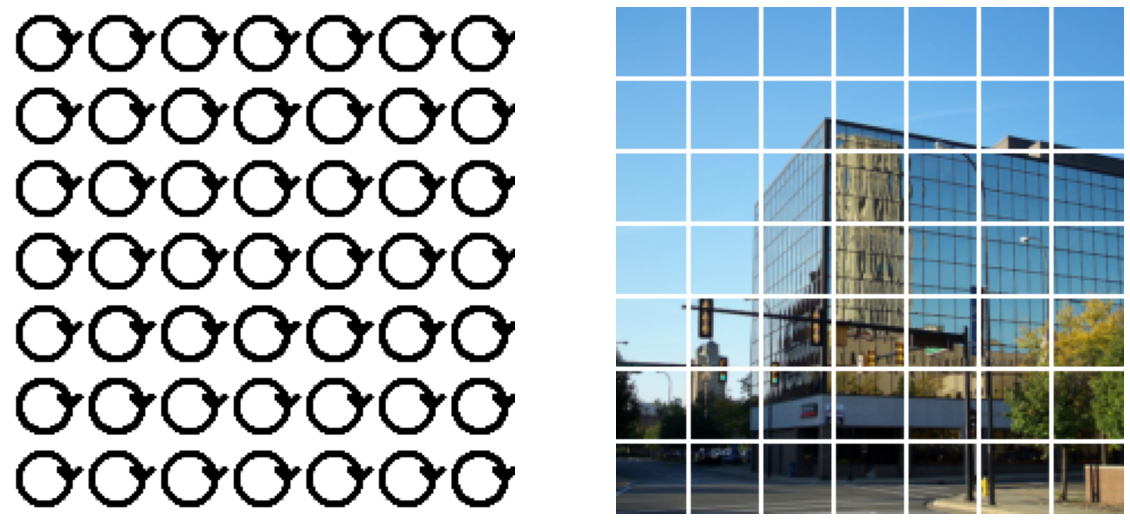

In [7]:
# layer = 1
# head = 11
# layer = 4
# head = 10
# layer = 5
# head = 1

layer = 0
head = 8

index = 488
model = "vit-32"

# layer = token['layer']
# head = token['head']
# index = token['index']

# get info for the clicked on token
if model == "bert":
    all_token_info = dataService.token_data_bert['tokens'][index]
    offset = len(dataService.token_data_bert['tokens']) / 2
elif model == "vit-32":
    all_token_info = copy.copy(dataService.token_data_vit_32['tokens'][index])

if model == "vit-32":
    start = index - \
        (all_token_info['position_row'] * 7 +
         all_token_info['position_col'] + 1)
    end = start + 50
    image = read_image_from_dataurl64(
        dataService.token_data_vit_32['tokens'][start]['originalImagePath']).copy()
    if dataService.token_data_vit_32['tokens'][index]['type'] == "key":
        color = [227, 55, 143]
        start -= 50
        end -= 50
    else:
        color = [71, 222, 93]
    highlighted_image = highlight_a_patch(image.copy(), all_token_info['position_row'], all_token_info['position_col'],
                                          32, width=3, c=color)

    all_token_info['originalImagePath'] = convert_np_image_to_dataurl64(
        highlighted_image)

# now get attn info
if model == "bert":
    attn_data = dataService.attention_data_bert
    agg_attns = dataService.agg_att_data_bert['{}_{}'.format(
        layer, head)][:num_tokens]
elif model == "vit-32":
    attn_data = dataService.attention_data_vit_32

for plot in attn_data:
    if plot['layer'] == layer and plot['head'] == head:
        attns = plot['tokens'][start:end]
        if model == "vit-32" and all_token_info['type'] == "key":
            attns_vis = plot['tokens'][start + 50:end + 50]
        elif model == "vit-16"and all_token_info['type'] == "key":
            attns_vis = plot['tokens'][start + 197:end + 197]
        else:
            attns_vis = plot['tokens'][start:end]
        break

attn = [t['attention'] for t in attns]
attns_vis = [t['attention'] for t in attns_vis]
agg_attn = [] if model not in ["bert", "gpt"] else normalize_attn([t['attention'][:num_tokens]
                                                                   for t in agg_attns])
norms = [] if model != "gpt" else [t['value_norm'] for t in attns]
agg_norms = [] if model != "gpt" else [t['value_norm'] for t in agg_attns]

if model == "vit-32":
    # overlaid_image = overlay_image_with_attention(image.copy(), attn[index % 49], 32,
    #                                               norm_attention=True if dataService.token_data_vit_32['tokens'][index]['type'] == "query" else False)
    overlaid_image = overlay_image_with_attention(
        image.copy(), attns_vis[index % 50], 32)
    overlaid_image = highlight_patches(overlaid_image, 32)

    if dataService.token_data_vit_32['tokens'][index]['type'] == "key":
        color = [227, 55, 143]
    else:
        color = [71, 222, 93]

    if index % 50 == 0:
        cls_color = color
    else:
        cls_color = [0, 0, 0]
    overlaid_image = append_cls(
        overlaid_image, attn[index % 50], cls_color, )
    overlaid_image = highlight_a_patch(overlaid_image, all_token_info['position_row'], all_token_info['position_col'],
                                       32, width=3, c=color)
    all_token_info['originalPatchPath'] = convert_np_image_to_dataurl64(
        overlaid_image)

    arrowed_image = highlight_patches(image.copy(), 32)
    resize_factor = 8
#     arrowed_image = draw_arrow_on_image(arrowed_image, attn, 32 * resize_factor, thickness=30, resize_factor=resize_factor, enhance_contrast=False,
#                                         color=[255, 40, 40])
    print(image.shape)
    attention_line = draw_arrow_on_image(np.zeros(shape=image.shape, dtype="uint8"), attn, 32 * resize_factor, thickness=24, resize_factor=resize_factor,
                                        enhance_contrast=False,
                                        color=[0, 0, 0])
    attention_line = resize_image(attention_line, 1/resize_factor)

#     all_token_info['sentence'] = convert_np_image_to_dataurl64(arrowed_image)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(attention_line)
ax[0].axis("off")

ax[1].imshow(arrowed_image)
ax[1].axis("off")

In [10]:
np.unique(attention_line)

array([  0,  29,  44,  46,  48,  72, 115, 172, 176, 195, 211, 241, 250,
       254, 255], dtype=uint8)

In [ ]:
image.shape

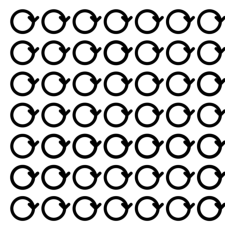

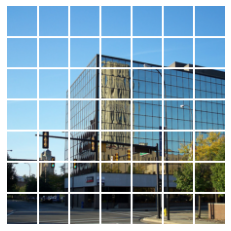

In [45]:
plt.figure()
plt.imshow(attention_line)
plt.axis("off")
plt.show()

plt.figure()
plt.imshow(arrowed_image)
plt.axis("off")
plt.show()

array([245, 230,  50,   0], dtype=uint8)

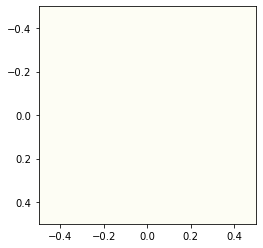

In [38]:
arrowed_image[200, 6]

plt.imshow(arrowed_image[200, 6].reshape(1, 1, 4))
arrowed_image[198, 6]

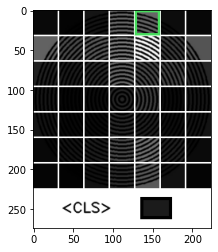

In [18]:
plt.imshow(overlaid_image)

(-0.5, 127.5, 127.5, -0.5)

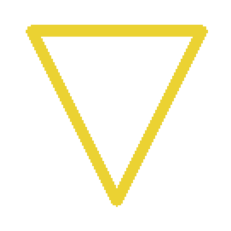

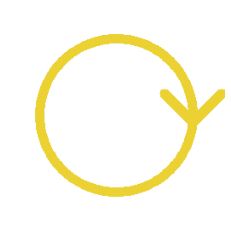

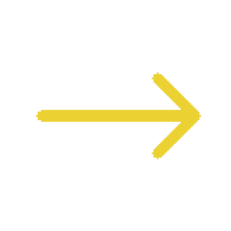

In [64]:
# pad = np.zeros(shape=(128, 128, 3), dtype=np.uint8) + [243, 243, 243]
pad = np.zeros(shape=(128, 128, 3), dtype=np.uint8) + [255, 255, 255]


image = cv2.drawMarker(pad,
                       position=(64,
                                 64),
                       markerType=cv2.MARKER_TRIANGLE_DOWN,
                       markerSize=10 * 10,
                       thickness=5,
                       color=[235, 210, 50],
                       line_type=cv2.LINE_AA)

plt.figure()
plt.imshow(pad)
plt.axis("off")


# pad = np.zeros(shape=(256, 256, 3), dtype=np.uint8) + [243, 243, 243]
pad = np.zeros(shape=(256, 256, 3), dtype=np.uint8) + [255, 255, 255]

pad = cv2.circle(pad,
                   center=(128,
                           128),
                   radius=90, 
                   thickness=9,
                   color=[235, 210, 50],
                   lineType=cv2.LINE_AA)

pad = cv2.arrowedLine(pad,
                    pt1=(128 + 90,
                         128),
                    pt2=(128 + 90,
                         128 + 8),
                    thickness=9,
                    color=[235, 210, 50],
                    line_type=cv2.LINE_AA,
                    tipLength=6)

plt.figure()
plt.imshow(pad)
plt.axis("off")


# pad = np.zeros(shape=(128, 128, 3), dtype=np.uint8) + [243, 243, 243]
pad = np.zeros(shape=(128, 128, 3), dtype=np.uint8) + [255, 255, 255]

pad = cv2.arrowedLine(pad,
                    pt1=(20,
                         64),
                    pt2=(110,
                         64),
                    thickness=5,
                    color=[235, 210, 50],
                    line_type=cv2.LINE_AA,
                    tipLength=0.35)

plt.figure()
plt.imshow(pad)
plt.axis("off")